# Volatility & Correlation Calculations

In [47]:
import sys
sys.path.append('../Functions/')

from VolatilityCorrelationOEX import VolatilityCorrelation

vol = VolatilityCorrelation()

import pandas as pd
import matplotlib.pyplot as plt

### Import The data via Pandas

In [48]:
price_constituents=pd.read_csv('../../data/price/constituents_oex_cleansed.csv',index_col=0)
returns_constituents=price_constituents.pct_change().dropna()

price_oex=pd.read_csv('../../data/price/price_oex.csv',index_col=0)

In [49]:
df_imv_constituents=pd.read_csv('../../Data/ATM_IV_Constituents.csv',index_col=0)
df_imv_constituents.index=pd.to_datetime(df_imv_constituents.index)
df_imv_constituents.index=df_imv_constituents.index.tz_localize(None)

df_imv_oex=pd.read_csv('../../Data/at_imv_oex.csv',index_col=0)
df_imv_oex.index=pd.to_datetime(df_imv_oex.index)
df_imv_oex.index=df_imv_oex.index.tz_localize(None)

df_weights = pd.read_csv('../../Data/Weigths_OEX_PCA.csv',index_col=0)

In [50]:
df_imv_oex

OEX
Date             
2018-12-31  23.08
2019-01-03  23.74
2019-01-04  20.16
2019-01-07  19.42
2019-01-08  18.71
...           ...
2021-12-27  13.25
2021-12-28  13.34
2021-12-29  13.82
2021-12-30  16.15
2021-12-31  13.17

[757 rows x 1 columns]

In [51]:
df_imv_oex

OEX
Date             
2018-12-31  23.08
2019-01-03  23.74
2019-01-04  20.16
2019-01-07  19.42
2019-01-08  18.71
...           ...
2021-12-27  13.25
2021-12-28  13.34
2021-12-29  13.82
2021-12-30  16.15
2021-12-31  13.17

[757 rows x 1 columns]

In [52]:
df_weights

coef  std err       t  P>|t|  [0.025  0.975]
GS     0.0788    0.013   6.187  0.000   0.054   0.104
UNP    0.0469    0.015   3.116  0.002   0.017   0.076
LIN    0.1240    0.015   8.065  0.000   0.094   0.154
BLK    0.1582    0.015  10.699  0.000   0.129   0.187
MCD    0.0803    0.016   5.127  0.000   0.050   0.111
V      0.1354    0.026   5.300  0.000   0.085   0.186
MA     0.0783    0.021   3.663  0.000   0.036   0.120
CMCSA  0.1110    0.014   8.078  0.000   0.084   0.138

In [53]:
weighted_imv_constituents = (df_weights.coef.tolist()*df_imv_constituents).sum(axis=1)

### Plot implied volatility of the OEX and Subset

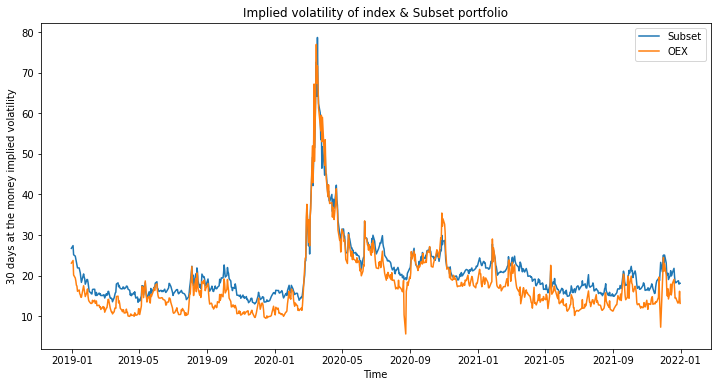

In [54]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


plt.figure(figsize=(12,6))
#plot of the volatility of the index & tracking portfolio
ax = plt.gca()
#date formatting
formatter = mdates.DateFormatter("%Y") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels

plt.plot(weighted_imv_constituents, label='Subset')
plt.plot(df_imv_oex, label='OEX')

#ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
#ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis
plt.title("Implied volatility of index & Subset portfolio")
plt.xlabel("Time")
plt.ylabel("30 days at the money implied volatility")
plt.legend()
plt.savefig('../../Graphs/implied_vol_index_trackng.png')
plt.show()

In [55]:
print(f"Lowest IV at date {df_imv_oex.idxmin()}, with values {df_imv_oex.min()}")

Lowest IV at date OEX   2020-08-24
dtype: datetime64[ns], with values OEX    5.64
dtype: float64


## Dispersion

The function to calculate the amount of dispersion according to CBOE

![image](../../graphs/dispersion_function.png)

In [56]:
dispersion = vol.dispersion(df_imv_oex,df_imv_constituents,df_weights.coef.tolist())
dispersion.index=pd.to_datetime(dispersion.index)
dispersion.head(5)

Date
2018-12-31    181.640997
2019-01-03    187.016776
2019-01-04    225.925791
2019-01-07    238.232740
2019-01-08    229.243852
dtype: float64

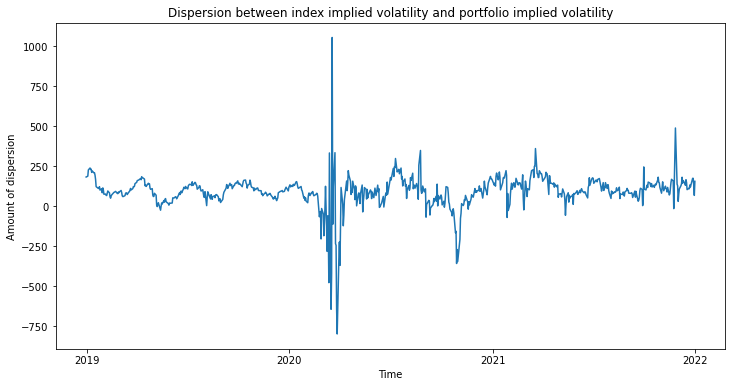

In [57]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
#plotting
formatter = mdates.DateFormatter("%Y") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels

#plot of the disperision 
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis

plt.plot(dispersion)
plt.title("Dispersion between index implied volatility and portfolio implied volatility")
plt.xlabel("Time")
plt.ylabel("Amount of dispersion")
plt.savefig("../../Graphs/dispersion_oex.png")
plt.show()

In [58]:
ma_dispersion = dispersion.rolling(30).mean()
ma_std_dispersion = dispersion.rolling(30).std()
bol_up_dispersion = ma_dispersion+(1.5*ma_std_dispersion)
bol_down_dispersion= ma_dispersion-(1.5*ma_std_dispersion)

In [59]:
short_dis=pd.DataFrame()
long_dis=pd.DataFrame()
short_dis['amount_dis'] = dispersion[dispersion.values<bol_down_dispersion.values]
long_dis['amount_dis'] = dispersion[dispersion.values>bol_up_dispersion.values]


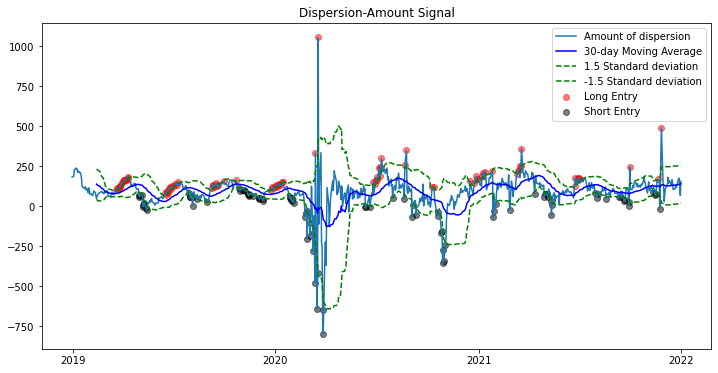

In [60]:
plt.figure(figsize=(12,6))

#plotting
formatter = mdates.DateFormatter("%Y") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels

#plot of the disperision 
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis

#plot circle on trade moments
plt.scatter(long_dis.index, long_dis, label='Long Entry', alpha=0.5, color='r')
plt.scatter(short_dis.index, short_dis, label='Short Entry', alpha=0.5, color='k')

plt.title('Dispersion-Amount Signal')
plt.plot(dispersion,label='Amount of dispersion')
plt.plot(ma_dispersion,color='b',label='30-day Moving Average')
plt.plot(bol_up_dispersion,linestyle='--',color='g',label='1.5 Standard deviation')
plt.plot(bol_down_dispersion,linestyle='--',color='g',label='-1.5 Standard deviation')
plt.legend()
plt.savefig('../../Graphs/Dispersion_amount_signal.png')
plt.show()

In [61]:
short_dis['trade']='Short'
long_dis['trade']='Long'

short_dis=short_dis.drop(columns='amount_dis')
long_dis=long_dis.drop(columns='amount_dis')

short_dis
long_dis

df_entry_dis=pd.DataFrame()
df_entry_dis=df_entry_dis.append(long_dis)
df_entry_dis=df_entry_dis.append(short_dis)
df_entry_dis=df_entry_dis.sort_index()
df_entry_dis.to_csv("../../data/signals/entry_signal_dispersion.csv")

<ipython-input-61-7bc3c14c49bc>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_entry_dis=df_entry_dis.append(long_dis)
<ipython-input-61-7bc3c14c49bc>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_entry_dis=df_entry_dis.append(short_dis)


## Realized Volatility (30-day)

Formula for the variance of a portfolio:

![image](../../graphs/portfolio_variance.png)

Squareroot of the variance will result in the Volatility 

In [62]:
index_vol = vol.index_volatility(price_oex)
index_vol.index=pd.to_datetime(index_vol.index)
index_vol.index=index_vol.index.tz_localize(None)

In [63]:
df=df_imv_oex.join(index_vol)
df["Diff"]=df.CLOSE-df.OEX

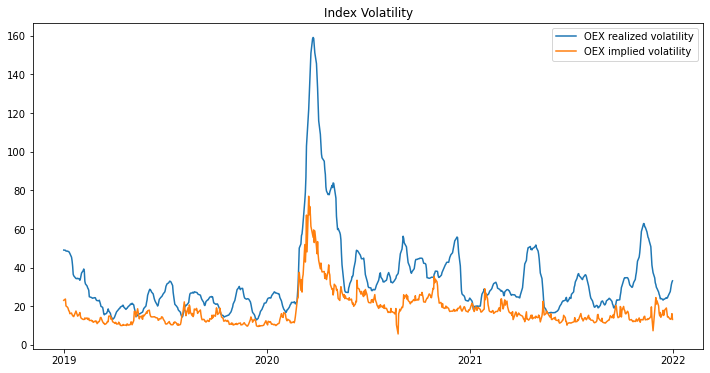

In [64]:
plt.figure(figsize=(12,6))

#plotting
formatter = mdates.DateFormatter("%Y") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels

#plot of the disperision 
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axisportoflio_variance=vol.portfolio_variance(price_constituents,df_weights)

plt.title("Index Volatility")
plt.plot(df.CLOSE, label="OEX realized volatility")
plt.plot(df.OEX, label="OEX implied volatility")
plt.legend()
plt.show()


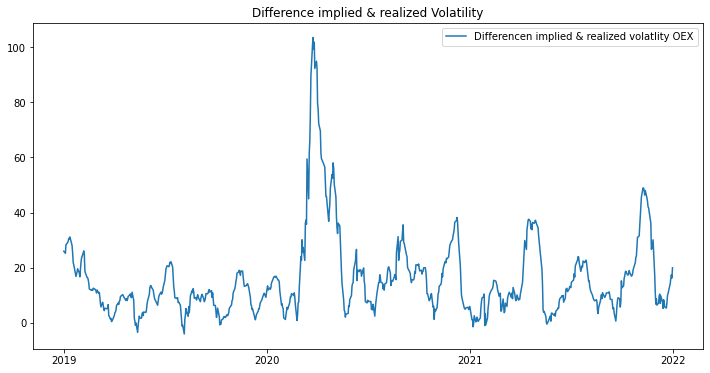

In [65]:
plt.figure(figsize=(12,6))

#plotting
formatter = mdates.DateFormatter("%Y") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels

#plot of the disperision 
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axisportoflio_variance=vol.portfolio_variance(price_constituents,df_weights)


plt.title("Difference implied & realized Volatility")
plt.plot(df.Diff,label="Differencen implied & realized volatlity OEX")
plt.legend()
plt.show()

## Perfect Pairwise correlation Signal 

![image](https://i2.wp.com/bsic.it/wp-content/uploads/2017/11/word-image-4.png?w=764&ssl=1)


In [66]:
pairwise_corr_signal=vol.pairwise_corr_signal(df_imv_oex,df_weights,returns_constituents)
pairwise_corr_signal.index=pairwise_corr_signal.Date
pairwise_corr_signal=pairwise_corr_signal.drop(columns=['Date'])

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future vers

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future vers

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future vers

../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future vers

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future vers

../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future vers

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future vers

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future vers

../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future vers

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future vers

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairwise_corr_signal=pairwise_corr_signal.append(df)
../Functions\VolatilityCorrelationOEX.py:184: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x=df_imv_oex[df_imv_oex.index.date==std.iloc[row].name]
../Functions\VolatilityCorrelationOEX.py:187: FutureWarning: The fra

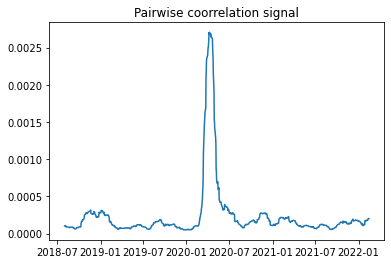

In [67]:
plt.title("Pairwise coorrelation signal")
plt.plot(pairwise_corr_signal.signal)

In [68]:
pairwise_corr_signal_ma = pairwise_corr_signal.rolling(30).mean()
pairwise_corr_signal_std = pairwise_corr_signal.rolling(30).std()
bol_up_pairwise = pairwise_corr_signal_ma+(1.5*pairwise_corr_signal_std)
bol_down_pairwise = pairwise_corr_signal_ma-(1.5*pairwise_corr_signal_std)

In [69]:
pairwise_corr_signal

signal
Date                
2018-08-01  0.000102
2018-08-02  0.000104
2018-08-03  0.000105
2018-08-06  0.000106
2018-08-07  0.000092
...              ...
2022-02-08  0.000175
2022-02-09  0.000180
2022-02-10  0.000192
2022-02-11  0.000201
2022-02-14  0.000201

[892 rows x 1 columns]

In [70]:
short_pairwise = pairwise_corr_signal[pairwise_corr_signal.values<bol_down_pairwise.values]
long_pairwise = pairwise_corr_signal[pairwise_corr_signal.values>bol_up_pairwise.values]

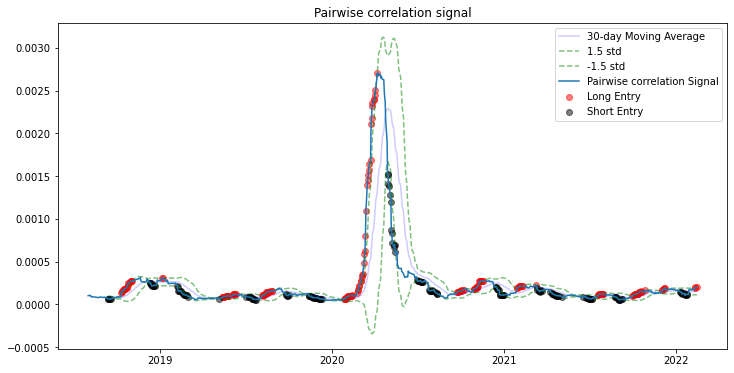

In [71]:
plt.figure(figsize=(12,6))

#plot circle on trade moments
plt.scatter(long_pairwise.index,long_pairwise.values, label='Long Entry', alpha=0.5, color='r')
plt.scatter(short_pairwise.index,short_pairwise.values, label='Short Entry', alpha=0.5, color='k')

#plotting
formatter = mdates.DateFormatter("%Y") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels

ax = plt.gca()
ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis



plt.title("Pairwise correlation signal")
plt.plot(pairwise_corr_signal_ma, color='b',label="30-day Moving Average",alpha=0.2)
plt.plot(bol_up_pairwise, label="1.5 std",linestyle='--',color="g",alpha=0.5)
plt.plot(bol_down_pairwise,label="-1.5 std",linestyle='--',color="g",alpha=0.5)
plt.plot(pairwise_corr_signal,label="Pairwise correlation Signal")
plt.legend()
plt.savefig('../../Graphs/Entry_Signal_Indiator_PairWiseCorr.png')
plt.show()



In [72]:
short_pairwise["trade"]="Short"
long_pairwise["trade"]="Long"

<ipython-input-72-364e544bddd0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_pairwise["trade"]="Short"
<ipython-input-72-364e544bddd0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_pairwise["trade"]="Long"


In [73]:
entery_signal_pairwise = pd.concat([short_pairwise,long_pairwise])
entery_signal_pairwise = entery_signal_pairwise.sort_index()
entery_signal_pairwise = entery_signal_pairwise.drop(columns='signal')
entery_signal_pairwise

trade
Date             
2018-09-12  Short
2018-09-13  Short
2018-09-14  Short
2018-09-17  Short
2018-09-18  Short
...           ...
2022-01-24  Short
2022-01-25  Short
2022-02-10   Long
2022-02-11   Long
2022-02-14   Long

[329 rows x 1 columns]

In [74]:
entery_signal_pairwise.to_csv("../../data/signals/pairwise_entry.csv")

## Implied correlation

Formula:
![image](../../graphs/implied_correlation_function.png)

In [75]:
i_corr = vol.implied_correlation(df_imv_oex,df_imv_constituents,df_weights.coef.tolist())
i_corr

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr=df_implied_corr.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:91: FutureWarning: The frame.append method is d

implied_corr       Date
0       0.265170 2018-12-31
0       0.267887 2019-01-03
0       0.220003 2019-01-04
0       0.207247 2019-01-07
0       0.205166 2019-01-08
..           ...        ...
0       0.156280 2021-12-27
0       0.160060 2021-12-28
0       0.199070 2021-12-29
0       0.284818 2021-12-30
0       0.169079 2021-12-31

[757 rows x 2 columns]

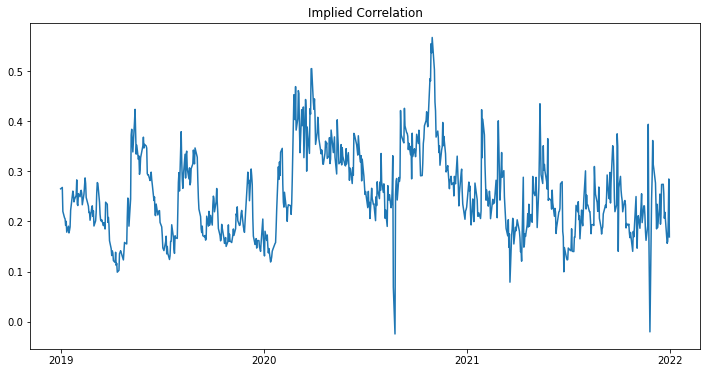

In [76]:
i_corr['Date']= pd.to_datetime(i_corr['Date'])


#plotting
formatter = mdates.DateFormatter("%Y") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels

plt.figure(figsize=(12,6))
plt.title("Implied Correlation")

#plot of the disperision 

ax = plt.gca()
ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis


plt.plot(i_corr.Date,i_corr.implied_corr)

## Sample Correlation
Formula:
![image](../../graphs/correlation_sample_formula.png)

In [77]:
import pandas as pd
import datetime

#import price constituents
price_portfolio=pd.read_csv("../../Data/price/constituents_oex_cleansed.csv",index_col=0)
price_portfolio.index=pd.to_datetime(price_portfolio.index)

#calculate returns
ret_portfolio=price_portfolio.pct_change().dropna()

In [78]:
ret_portfolio = ret_portfolio[df_weights.index]
ret_portfolio

GS       UNP       LIN       BLK       MCD         V  \
Date                                                                     
2018-06-20 -0.002190  0.003851 -0.001867 -0.000057 -0.014609  0.002887   
2018-06-21 -0.003687 -0.001813  0.005483 -0.003038 -0.012488 -0.007159   
2018-06-22 -0.004229  0.005940  0.014564 -0.004267  0.025042  0.005947   
2018-06-25 -0.019821 -0.018895 -0.021121 -0.014539 -0.028806 -0.032513   
2018-06-26  0.000181  0.000212 -0.003941 -0.008328  0.006883  0.012373   
...              ...       ...       ...       ...       ...       ...   
2022-02-08  0.005297  0.007464  0.007556 -0.011666  0.000885  0.003434   
2022-02-09  0.011970  0.014571  0.018212  0.006948 -0.000846  0.012854   
2022-02-10 -0.010573 -0.017729  0.015453 -0.042817 -0.011506 -0.021280   
2022-02-11 -0.020266 -0.013671 -0.045718 -0.007325 -0.006657 -0.003990   
2022-02-14 -0.007767  0.015661 -0.004139 -0.015767 -0.006937  0.002893   

                  MA     CMCSA  
Date                            
2018-06-20  0.009264  0.017677  
2018-06-21 -0.003771 -0.017969  
2018-06-22  0.003486  0.031107  
2018-06-25 -0.032261 -0.020408  
2018-06-26  0.007591 -0.010266  
...              ...       ...  
2022-02-08 -0.004679  0.007163  
2022-02-09  0.018698  0.011380  
2022-02-10 -0.018302 -0.017079  
2022-02-11 -0.012340 -0.026574  
2022-02-14  0.011872 -0.004620  

[921 rows x 8 columns]

In [79]:
sample_correlation = vol.sample_correlation(ret_portfolio,df_imv_constituents,df_weights.coef.tolist())
sample_correlation

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorrelationOEX.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_implied_corr_sample=df_implied_corr_sample.append(df_temp)
../Functions\VolatilityCorre

implied_corr       Date
0       0.211575 2018-12-31
0       0.158800 2019-01-03
0       0.145521 2019-01-04
0       0.151673 2019-01-07
0       0.112042 2019-01-08
..           ...        ...
0       0.394546 2021-12-27
0       0.331269 2021-12-28
0       0.297891 2021-12-29
0       0.339945 2021-12-30
0       0.390137 2021-12-31

[757 rows x 2 columns]

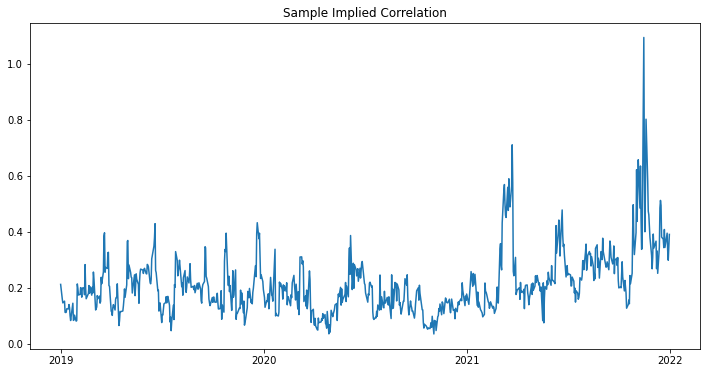

In [80]:
#plotting
formatter = mdates.DateFormatter("%Y") ## formatter of the date
locator = mdates.YearLocator() ## where to put the labels

plt.figure(figsize=(12,6))
plt.title("Sample Implied Correlation")

#plot of the disperision 

ax = plt.gca()
ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis


plt.plot(sample_correlation.Date,sample_correlation.implied_corr)

## Indicator Implied Correlation & Sample Correlation
Formula:
![image](../../graphs/indicator_function.png)

In [81]:
i_corr = i_corr.set_index('Date')
sample_correlation = sample_correlation.set_index('Date')

In [82]:
indicator = vol.indicator(i_corr,sample_correlation)

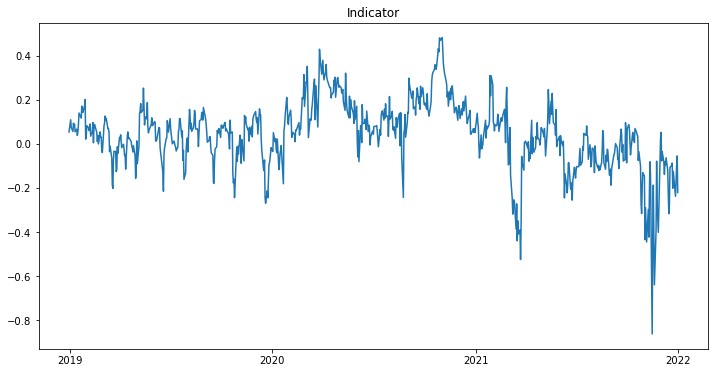

In [83]:
#plotting
formatter = mdates.DateFormatter("%Y") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels

plt.figure(figsize=(12,6))
plt.title("Indicator")

#plot of the disperision 

ax = plt.gca()
ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis


plt.plot(indicator)

In [84]:
moving_average = indicator.rolling(30).mean()
moving_std = indicator.rolling(30).std()
bol_up = moving_average+(1.5*moving_std)
bol_down = moving_average-(1.5*moving_std)

In [85]:
short = indicator[indicator.values<bol_down.values]
long = indicator[indicator.values>bol_up.values]

df_signal=pd.concat([short,long])

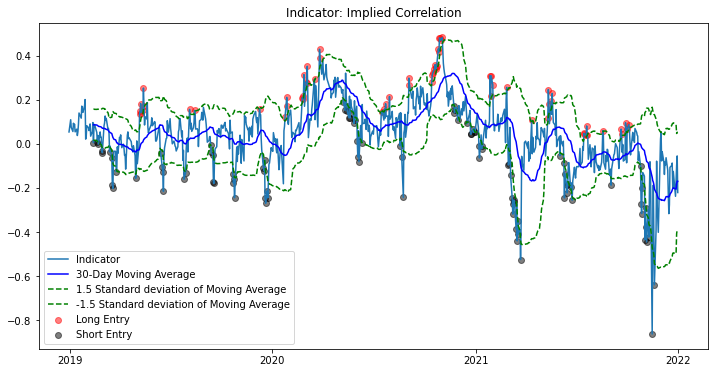

In [86]:
import matplotlib.patches as mpatches
#plotting
formatter = mdates.DateFormatter("%Y") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels

plt.figure(figsize=(12,6))
plt.title("Indicator: Implied Correlation")

ax = plt.gca()
ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis

#plot circle on trade moments
plt.scatter(long.index, long, label='Long Entry', alpha=0.5, color='r')
plt.scatter(short.index, short, label='Short Entry', alpha=0.5, color='k')

#plot of the disperision
plt.plot(indicator,label='Indicator')
plt.plot(moving_average,color='b',linestyle='-',label='30-Day Moving Average')
plt.plot(bol_up,color='g',linestyle='--',label='1.5 Standard deviation of Moving Average')
plt.plot(bol_down,color='g',linestyle='--',label='-1.5 Standard deviation of Moving Average')
plt.legend()
plt.savefig('../../Graphs/Entry_Signal_Indiator_IC.png')

In [87]:
short['trade']='Short'
long['trade']='Long'

<ipython-input-87-7e215b630edc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short['trade']='Short'
<ipython-input-87-7e215b630edc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long['trade']='Long'


In [88]:
entery_signal = pd.concat([short,long])
entery_signal = entery_signal.sort_index()
entery_signal = entery_signal.drop(columns='implied_corr')
entery_signal

trade
Date             
2019-02-13  Short
2019-02-20  Short
2019-02-22  Short
2019-02-28  Short
2019-03-01  Short
...           ...
2021-11-04  Short
2021-11-05  Short
2021-11-09  Short
2021-11-15  Short
2021-11-19  Short

[162 rows x 1 columns]

In [89]:
entery_signal.to_csv('../../Data/signals/Entery_Signal.csv')